# Classification Models and Hyperparameter Finetuning

In [39]:
import matplotlib.pyplot as plt
#%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics 
from sklearn.datasets import make_classification
#from xgboost import XGBClassifier
#!pip install xgboost scikit-learn pandas numpy
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import pickle

In [40]:
def classificationMetrics(y, yhat):
    prf1 = metrics.precision_recall_fscore_support(y,yhat)
    res = {'Accuracy': metrics.accuracy_score(y,yhat),
           'Precision':prf1[0][1],
           'Recall': prf1[1][1],
           'f1-score': prf1[2][1],
           'Log-loss': metrics.log_loss(y,yhat),
           'AUC': metrics.roc_auc_score(y,yhat)
          }
    return res

## Data

In [68]:
# load df for modeling
with open("../pickles/df_model.pkl", "rb") as f:
    df_model = pickle.load(f)  

# load dev for modeling
with open("../pickles/dev.pkl", "rb") as f:
    dev = pickle.load(f)  

# load test for modeling
with open("../pickles/test.pkl", "rb") as f:
    test = pickle.load(f)  

# load train for modeling
with open("../pickles/train.pkl", "rb") as f:
    train = pickle.load(f)  

In [69]:
df_model

,home_Goals,away_Goals,home_GoalsHalfTime,home_xGoals,home_shots,home_ppda,home_corners,home_total_assists,away_xGoals,away_ppda,away_total_assists,away_total_red_cards,home_shotsOnTarget_cat,away_shotsOnTarget_cat,home_total_assists_cat,away_total_assists_cat,home_Goals_cat,away_Goals_cat,gameresult
5437,2,2,2,1.367870,9.0,31.6000,1.0,2,2.655380,7.5000,2,0,3,6,2,2,2,2,1
5438,3,3,1,1.396890,14.0,5.7429,1.0,0,1.317510,4.7826,1,0,4,4,0,1,3,3,1
5439,0,3,0,0.813737,9.0,7.0000,5.0,0,1.238690,21.2143,2,0,2,7,0,2,0,3,0
5440,0,2,0,0.632940,6.0,16.0625,4.0,0,1.495320,10.7500,0,0,3,2,0,0,0,2,0
5441,0,0,0,1.544680,14.0,3.6087,8.0,0,0.057137,21.0556,0,0,3,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,1,2,1,1.411190,15.0,12.3684,9.0,1,1.707510,8.3529,1,0,5,5,1,1,1,2,0
12676,1,2,1,1.198190,10.0,16.2632,5.0,1,1.238050,27.0000,1,0,3,5,1,1,1,2,0
12677,2,0,1,1.332690,12.0,8.2857,4.0,1,0.357583,39.7273,0,0,6,2,1,0,2,0,2
12678,0,1,0,1.460500,19.0,7.5600,9.0,0,1.380290,14.7200,1,0,5,2,0,1,0,1,0


In [70]:
df_model.shape

(12680, 19)

In [71]:
dev.shape

(2536, 20)

Visual of the data created on stage 5 with RandomOverSample techniqe

[Text(0.5, 1.0, 'Data after Over Sampling')]

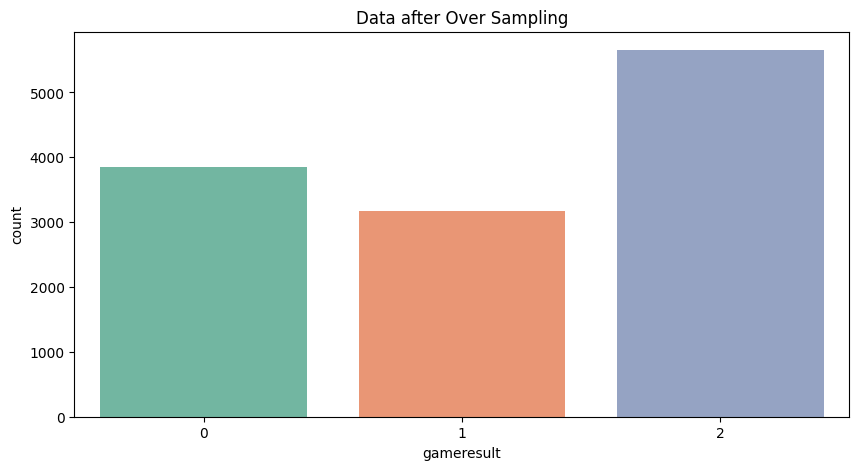

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df_model['gameresult'].dropna(),data=df_model, palette="Set2").set(title='Data after Over Sampling')

In [73]:
df_model['gameresult'].value_counts()

2    5654
0    3854
1    3172
Name: gameresult, dtype: int64

In [74]:
X_train = train.loc[:,train.columns != 'gameresult']
X_dev = dev.loc[:,dev.columns != 'gameresult']
y_train = train['gameresult']
y_dev = dev['gameresult']

In [85]:
y_dev

10682    0
10794    1
2455     2
6463     0
168      1
        ..
3475     1
1487     1
4070     0
4404     2
9411     2
Name: gameresult, Length: 2536, dtype: int64

## Supervised Models


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

In [76]:
models_list = pd.DataFrame()

In [82]:
X_dev['split'] = X_dev['split'].astype('category').cat.codes

X_dev.dtypes

home_Goals                  int64
away_Goals                  int64
home_GoalsHalfTime          int64
home_xGoals               float64
home_shots                float64
home_ppda                 float64
home_corners              float64
home_total_assists          int64
away_xGoals               float64
away_ppda                 float64
away_total_assists          int64
away_total_red_cards        int64
home_shotsOnTarget_cat    float64
away_shotsOnTarget_cat    float64
home_total_assists_cat    float64
away_total_assists_cat    float64
home_Goals_cat            float64
away_Goals_cat            float64
split                        int8
dtype: object

## Linear Regression

In [78]:
X_train.select_dtypes(include=['object']).nunique()


Series([], dtype: float64)

In [79]:
X_train.dtypes.sort_values()


home_Goals                  int64
away_Goals                  int64
home_GoalsHalfTime          int64
home_total_assists          int64
away_total_red_cards        int64
away_total_assists          int64
home_Goals_cat            float64
away_total_assists_cat    float64
home_total_assists_cat    float64
away_shotsOnTarget_cat    float64
home_shotsOnTarget_cat    float64
away_ppda                 float64
away_xGoals               float64
home_corners              float64
home_ppda                 float64
home_shots                float64
home_xGoals               float64
away_Goals_cat            float64
split                     float64
dtype: object

In [80]:
# X_train = X_train.drop(columns=['split'])  # example
# X_dev = X_dev.drop(columns=['split'])


In [83]:
# Option 1: Convert entire DataFrame (safe for encoded data)
X_dev = X_dev.apply(pd.to_numeric, errors='raise')
X_train = X_train.apply(pd.to_numeric, errors='raise')


In [86]:
mod1 = LogisticRegression(random_state=1, max_iter=1000)
mod1.fit(X_train,y_train)
pred1 = mod1.predict(X_dev)



In [89]:
print("y true= ",y_dev)

y true=  10682    0
10794    1
2455     2
6463     0
168      1
        ..
3475     1
1487     1
4070     0
4404     2
9411     2
Name: gameresult, Length: 2536, dtype: int64


In [90]:
print("y pred= ", pred1)

y pred=  [0 1 2 ... 0 2 2]


In [92]:
print("Classes in y_dev:", np.unique(y_dev))
print("Classes predicted:", np.unique(pred1))
print("Proba shape:", pred1.shape)


Classes in y_dev: [0 1 2]
Classes predicted: [0 1 2]
Proba shape: (2536,)
